In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.io
import scipy.signal as signal
from skimage.restoration import denoise_wavelet
from scipy.interpolate import interp1d
import colorednoise as cn


%matplotlib inline

In [3]:
df = pd.read_excel(r'F:\kaveri\frequency.xls')

In [4]:
df.head()

,Timestamp,BADARPUR:Frequency
0,2021-09-11 06:12:16.840,50.008
1,2021-09-11 06:12:16.880,50.008
2,2021-09-11 06:12:16.920,50.009
3,2021-09-11 06:12:16.960,50.009
4,2021-09-11 06:12:17.000,50.008


In [5]:
df['BADARPUR:Frequency']

0        50.008
1        50.008
2        50.009
3        50.009
4        50.008
          ...  
65530    49.981
65531    49.982
65532    49.982
65533    49.982
65534    49.982
Name: BADARPUR:Frequency, Length: 65535, dtype: float64

In [6]:
def calculate_psnr(signalnal, distorted_signal):
    # Ensure the signals have the same shape and data type
    # signalnal = signalnal.astype(np.float64)
    # distorted_signal = distorted_signal.astype(np.float64)

    # Calculate the mean squared error (MSE)
    mse = np.mean((signalnal - distorted_signal) ** 2)

    # Calculate the maximum possible power of the original signal
    max_power = np.max(signalnal) ** 2

    # Calculate the PSNR using the formula
    psnr = 10 * np.log10(max_power / mse)

    return psnr

In [7]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2):
    # Calculate the SSIM
    ssim_value = ssim(image1, image2, multichannel=False)

    return ssim_value

In [8]:
def find_params(reconstructed_signal, signal):
    print("snr of the signal needed is: ", 20*np.log10(reconstructed_signal.mean()/reconstructed_signal.std()))
    print("snr of the original signal is: ", 20*np.log10(signal.mean()/signal.std()))
    print('peaksnr of the signal needed is: ', calculate_psnr(signal, reconstructed_signal))
    print('Structure similarity index', calculate_ssim(signal, reconstructed_signal))
    print("Mean of reconstructed_signal: ", np.mean(reconstructed_signal))
    print("Median of reconstructed_signal: ", np.median(reconstructed_signal))
    print("Variance of reconstructed_signal: ", np.var(reconstructed_signal))
    print("Standard deviation of reconstructed_signal: ", np.std(reconstructed_signal))
    print('Correlation between original and reconstructed_signal: ', np.corrcoef(reconstructed_signal, signal)[0,1])
    print('frequency content/range of noise: ',np.abs(signal-reconstructed_signal).max())


In [13]:
# psd, skewness, kurtosis

def kaveri(t, signal):
    print(f'Kurtosis : {scipy.stats.kurtosis(signal)}')
    print(f'Skewness : {scipy.stats.skew(signal)}')

    f, Pxx_den = plt.psd(signal, NFFT=len(t), Fs=2*np.pi)

    # Plot the PSD
    plt.plot(f, Pxx_den)
    plt.xlabel('Frequency')
    plt.ylabel('Power spectral density')
    plt.show()

# Section of filters

def EMD(x):
    # Define stopping criterion
    MAXITER = 100
    TOLERANCE = 0.001
    
    # Initialize variables
    h = x
    d = np.zeros_like(x)
    n = 1
    
    # Loop until stopping criterion is met
    while n < MAXITER and np.abs(h).sum() > TOLERANCE:
        # Compute mean of envelope
        m = signal.hilbert(h).imag
        
        # Subtract mean from signal
        d += h - m
        
        # Update residual
        h = m
        
        # Increment iteration counter
        n += 1
        
    # Return IMF components and residual
    return d, h

def median_filter(signal, window_size = 10):
    """
    Applies a median filter to a signal to remove noise.
    Inputs:
        signal: numpy array containing the signal
        window_size: size of the window used for the filter
    Returns:
        filtered_signal: numpy array containing the filtered signal
    """
    # Pad the signal to handle edges
    signal_padded = np.pad(signal, int(window_size/2), mode='reflect')
    
    # Initialize the filtered signal
    filtered_signal = np.zeros_like(signal)
    
    # Loop through the signal and apply the median filter
    for i in range(len(signal)):
        window = signal_padded[i:i+window_size]
        filtered_signal[i] = np.median(window)
        
    return filtered_signal

def triangular_filter(signal, window_size):
    """
    Applies a moving average triangular filter to a signal to smooth it out.
    Inputs:
        signal: numpy array containing the signal
        window_size: size of the window used for the filter
    Returns:
        filtered_signal: numpy array containing the filtered signal
    """
    # Create a triangular window
    window = np.array(list(range(1, window_size//2+1)) + [window_size//2+1] + list(range(window_size//2, 0, -1)), dtype=np.float32)
    
    # Normalize the window
    window /= np.sum(window)
    
    # Apply the filter to the signal using convolution
    filtered_signal = np.convolve(signal, window, mode='same')
    
    return filtered_signal

def wavelet_filter(signal):
    """
    Applies a wavelet filter to a signal to remove noise.
    Inputs:
        signal: numpy array containing the signal
    Returns:
        filtered_signal: numpy array containing the filtered signal
    """
    # Apply the filter
    filtered_signal = denoise_wavelet(signal, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='db4', rescale_sigma=True)
    
    return filtered_signal

def eidft_clean(signal, sampling_rate, noise_std_dev):
    """
    Cleans noise from a signal using Enhanced Interpolated Discrete Fourier Transform.
    Inputs:
        signal: numpy array containing the noisy signal
        sampling_rate: sampling rate of the signal
        noise_std_dev: standard deviation of the noise
    Returns:
        cleaned_signal: numpy array containing the cleaned signal
    """
    # Compute the DFT of the noisy signal
    X = np.fft.fft(signal)
    
    # Compute the frequency-domain filter
    N = len(signal)
    f = np.arange(N) * sampling_rate / N
    filter = np.exp(-((2*np.pi*f)**2) / (2*(noise_std_dev**2)))
    
    # Apply the frequency-domain filter to the DFT of the signal
    X_filtered = X * filter
    
    # Compute the cleaned signal using the inverse DFT
    cleaned_signal = np.fft.ifft(X_filtered).real
    
    # Interpolate the cleaned signal to the original sampling rate
    t = np.arange(len(cleaned_signal))
    interp_func = interp1d(t, cleaned_signal, kind='cubic')
    t_interp = np.linspace(0, N-1, N) * (1/sampling_rate)
    filtered_signal = interp_func(t_interp)
    
    return filtered_signal

def extended_kalman_filter(signal, sampling_rate, noise_std_dev):
    """
    Cleans noise from a signal using Extended Kalman Filter.
    Inputs:
        signal: numpy array containing the noisy signal
        sampling_rate: sampling rate of the signal
        noise_std_dev: standard deviation of the noise
    Returns:
        cleaned_signal: numpy array containing the cleaned signal
    """
    # Define the state transition matrix
    A = np.array([[1, 1/sampling_rate], [0, 1]])
    
    # Define the observation matrix
    H = np.array([[1, 0]])
    
    # Define the process noise covariance matrix
    Q = np.array([[1, 0], [0, 1]])
    
    # Define the observation noise covariance matrix
    R = np.array([[noise_std_dev**2]])
    
    # Define the initial state estimate
    x = np.array([[signal[0]], [0]])
    
    # Define the initial error covariance matrix
    P = np.array([[1, 0], [0, 1]])
    
    # Initialize the cleaned signal
    filtered_signal = np.zeros_like(signal)
    
    # Loop through the signal and apply the Kalman filter
    for i in range(len(signal)):
        # Predict the next state
        x = A @ x
        
        # Predict the next error covariance matrix
        P = A @ P @ A.T + Q
        
        # Compute the Kalman gain
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)
        
        # Update the state estimate
        x = x + K @ (signal[i] - H @ x)
        
        # Update the error covariance matrix
        P = (np.eye(2) - K @ H) @ P
        
        # Save the cleaned signal
        filtered_signal[i] = x[0, 0]
        
    return filtered_signal

# Section of plots

def plot(t, signal, title, alpha=1):
    plt.figure(figsize=(20,8))
    plt.title(f'{signal}')
    plt.plot(t, signal, alpha=alpha)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(f'{title} analysis')
    if plt.gca().get_legend():
        plt.legend()

# Section of signal parameter analysis

def snr(filtered_signal):
    snr1 = 20*np.log10(filtered_signal.mean()/filtered_signal.std())
    print(f'snr: {snr1}')

def nrmse(filtered_signal):
    print(f"nrmse: {filtered_signal.std()/filtered_signal.mean()}")

def tve(filtered_signal, noisy_signal):
    print(f"tve: {np.linalg.norm((filtered_signal-noisy_signal)/noisy_signal)}")

def cr(filtered_signal, noisy_signal):
    print(f"cr: {np.ptp(filtered_signal)/np.ptp(noisy_signal)}")

def signal_params(filtered_signal, noisy_signal):
    return snr(filtered_signal), nrmse(filtered_signal), tve(filtered_signal, noisy_signal), cr(filtered_signal, noisy_signal)

# automation

def automate(title, signal, reconstructed_signal, noisy_signal, t):
    # Plot results
    title = title
    print(title)
    plot(t, reconstructed_signal, title=title)
    plt.plot(t, noisy_signal)
    title = 'Difference'
    plot(t, signal - reconstructed_signal, title=title)

    signal_params(reconstructed_signal, noisy_signal)
    plt.figure()
    kaveri(t, reconstructed_signal)

# actual function

def signal_analysis(signal, var = 0.003, noise_type = ['white', 'pink', '0.1 inc white', '0.1 inc pink', '0.1 dec white', '0.1 dec pink']):
    t = np.arange(0,signal.shape[0],1)

    print(f'Original signal analysis: ')
    kaveri(t, signal);
    find_params(signal, signal)
    signal_params(signal, signal)
    plot(t,signal, title = 'Original Signal');

    # Generate noisy signal
    if noise_type == 'white':
        n =  np.random.rand(signal.shape[0])
        noise = ((n - n.mean())/n.std())*var
    
    elif noise_type == 'pink':
        n = cn.powerlaw_psd_gaussian(1, signal.shape[0])
        noise = ((n - n.mean())/n.std())*var
    
    elif noise_type == '0.1 inc white':
        n =  np.random.rand(signal.shape[0])
        noise = ((n - n.mean())/n.std())*var
        noise = noise + 0.1*noise
    
    elif noise_type == '0.1 inc pink':
        n = cn.powerlaw_psd_gaussian(1, signal.shape[0])
        noise = ((n - n.mean())/n.std())*var
        noise = noise + 0.1*noise
    
    elif noise_type == '0.1 dec white':
        n =  np.random.rand(signal.shape[0])
        noise = ((n - n.mean())/n.std())*var
        noise = noise - 0.1*noise
    
    elif noise_type == '0.1 dec pink':
        n = cn.powerlaw_psd_gaussian(1, signal.shape[0])
        noise = ((n - n.mean())/n.std())*var
        noise = noise - 0.1*noise
    
        
        

    noisy_signal = signal + noise
    print(f'Noisy signal analysis: ');
    find_params(noisy_signal, signal)
    signal_params(noisy_signal, signal)
    plot(t,noisy_signal, title='Noisy Signal');


    print(f"EMD Analysis of signal")

    # Apply EMD
    IMFs = []
    residual = noisy_signal
    for i in range(10):
        imf, residual = EMD(residual)
        IMFs.append(imf)
    
    # Reconstruct signal using selected IMFs
    reconstructed_signal = np.sum(IMFs[:3], axis=0)

    find_params(reconstructed_signal, signal)


    # Plot results
    automate("EMD", signal, reconstructed_signal, noisy_signal, t)
    
    # apply Median

    reconstructed_signal = median_filter(noisy_signal, window_size = 10)

    

    # median analysis
    print(f"Median Analysis of signal")
    find_params(reconstructed_signal, signal)
    automate('Median Filter',signal, reconstructed_signal, noisy_signal, t)
    
    # apply Triangular
    reconstructed_signal = triangular_filter(noisy_signal, window_size = 10)


    # triangular analysis
    print(f"Triangular Analysis of signal")
    find_params(reconstructed_signal, signal)
    automate('Triangular Filter',signal, reconstructed_signal, noisy_signal, t)

    # apply Wavelet
    reconstructed_signal = wavelet_filter(noisy_signal)

    # wavelet analysis
    print(f"Wavelet Analysis of signal")
    find_params(reconstructed_signal, signal)
    automate('Wavelet Filter',signal, reconstructed_signal, noisy_signal, t)
    
    # apply EIDFT
    reconstructed_signal = eidft_clean(signal, sampling_rate =1, noise_std_dev = 0.5)

    # eidft analysis
    print(f"EIDFT Analysis of signal")
    find_params(reconstructed_signal, signal)
    automate('EIDFT Filter',signal, reconstructed_signal, noisy_signal, t)

    # apply EKF
    reconstructed_signal = extended_kalman_filter(signal, sampling_rate =1, noise_std_dev = 0.5)

    # ekf analysis
    print(f"EKF Analysis of signal")
    find_params(reconstructed_signal, signal)
    automate('EKF Filter',signal, reconstructed_signal, noisy_signal, t)




    
    


Original signal analysis: 
Kurtosis : -0.7962090526109451
Skewness : 0.13436966529721817


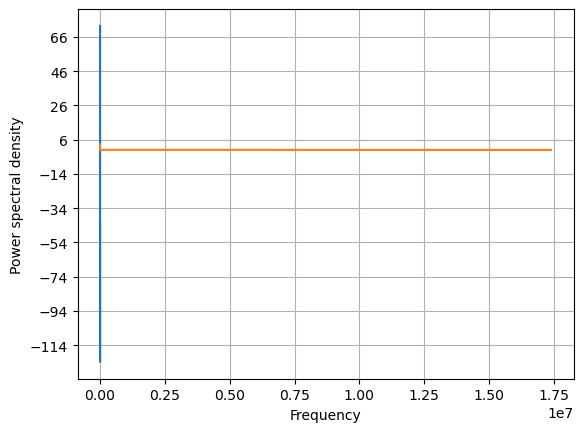

snr of the signal needed is:  63.359398370474736
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  inf
Structure similarity index 1.0
Mean of reconstructed_signal:  50.00740880445562
Median of reconstructed_signal:  50.008
Variance of reconstructed_signal:  0.001153777961697126
Standard deviation of reconstructed_signal:  0.0339673072482516
Correlation between original and reconstructed_signal:  0.9999999999999998
frequency content/range of noise:  0.0
snr: 63.359398370474736
nrmse: 0.0006792506793940005
tve: 0.0
cr: 1.0
Noisy signal analysis: 
snr of the signal needed is:  63.372344969998124
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  83.62439501798347
Structure similarity index 0.9993235421201816
Mean of reconstructed_signal:  50.007408804455636
Median of reconstructed_signal:  50.007793103186636
Variance of reconstructed_signal:  0.0011503435965118651
Standard deviation of reconstructed_signal:  0.0339167155

C:\Users\BC\AppData\Local\Temp\ipykernel_11608\3835163184.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  psnr = 10 * np.log10(max_power / mse)
C:\Users\BC\AppData\Local\Temp\ipykernel_11608\2558271908.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(image1, image2, multichannel=False)


snr of the signal needed is:  60.36211128295382
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  63.273718891916964
Structure similarity index 0.9985459269801901
Mean of reconstructed_signal:  50.007408804455636
Median of reconstructed_signal:  50.00830343318955
Variance of reconstructed_signal:  0.002300687193023832
Standard deviation of reconstructed_signal:  0.04796547918059229
Correlation between original and reconstructed_signal:  0.6978283142117662
frequency content/range of noise:  0.09464395825857252
EMD
snr: 60.36211128295382
nrmse: 0.0009591674579291256
tve: 0.17362096944802632
cr: 1.3843324411761402
Kurtosis : -0.8722024163896163
Skewness : 0.16467170432487924


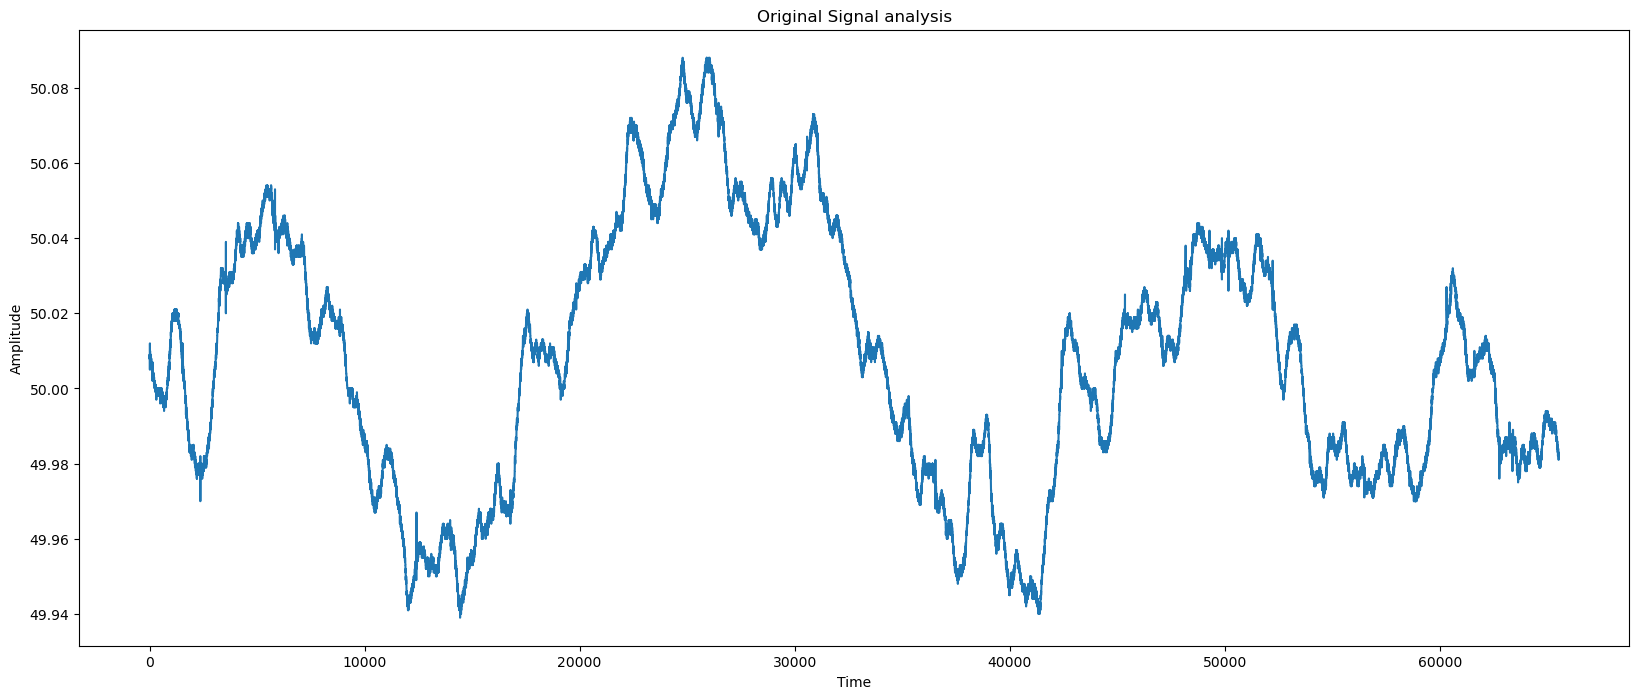

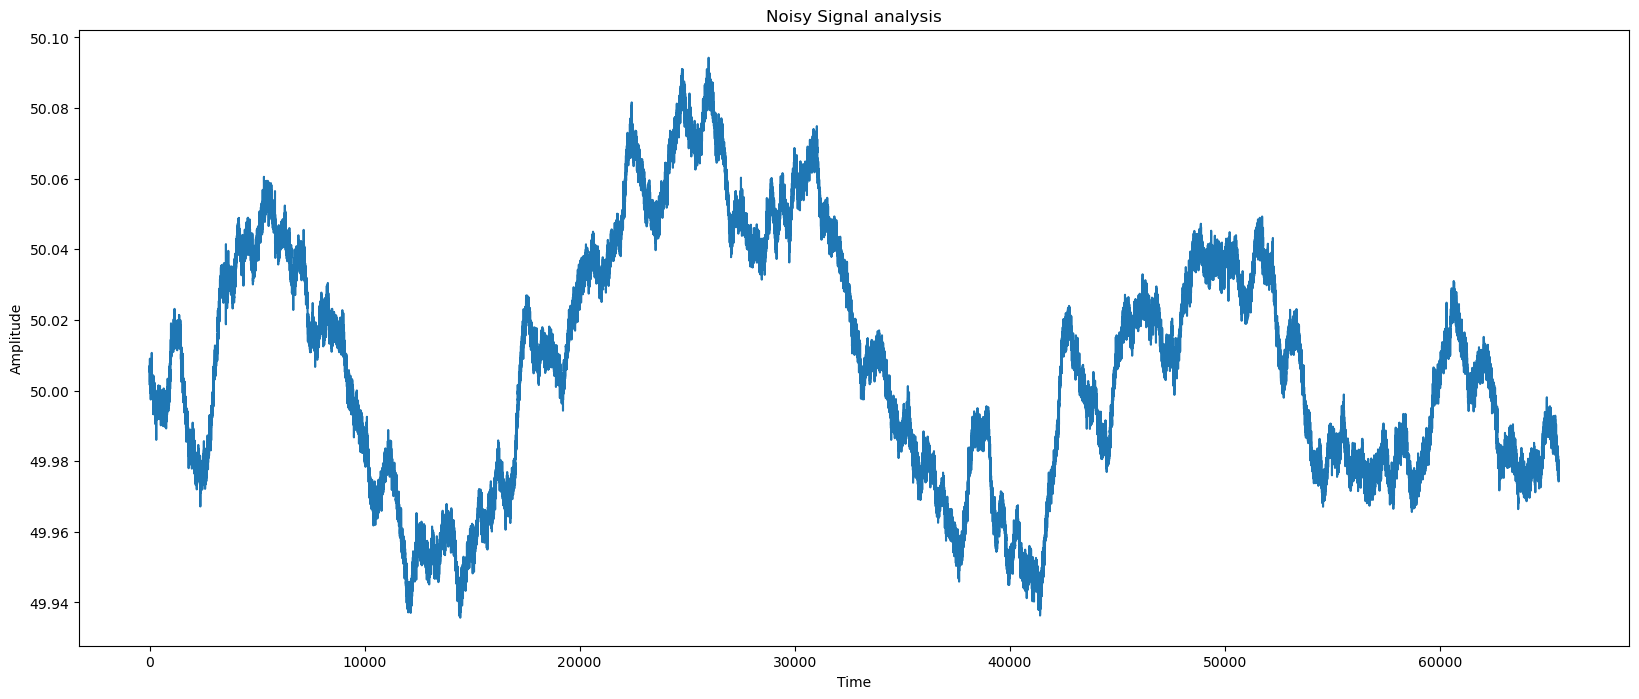

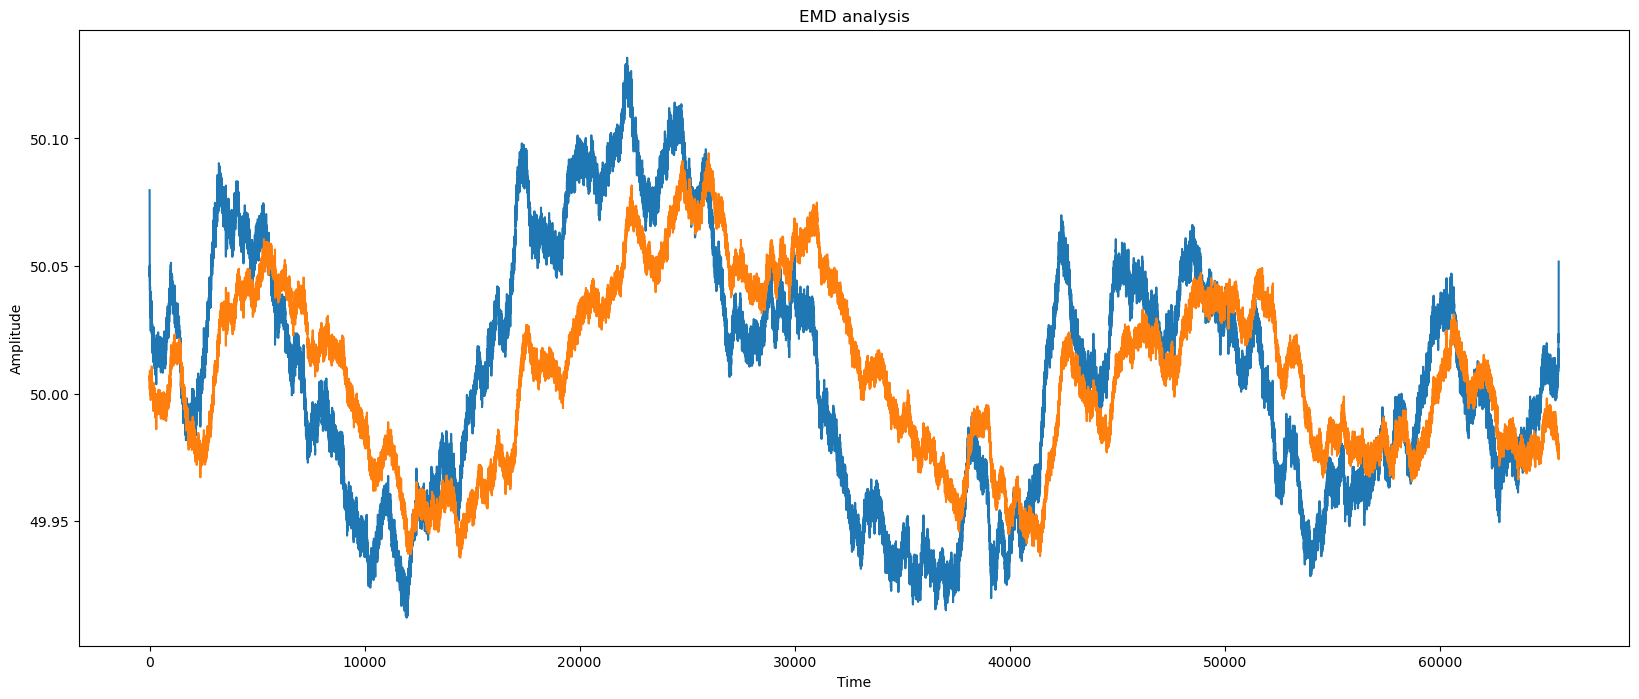

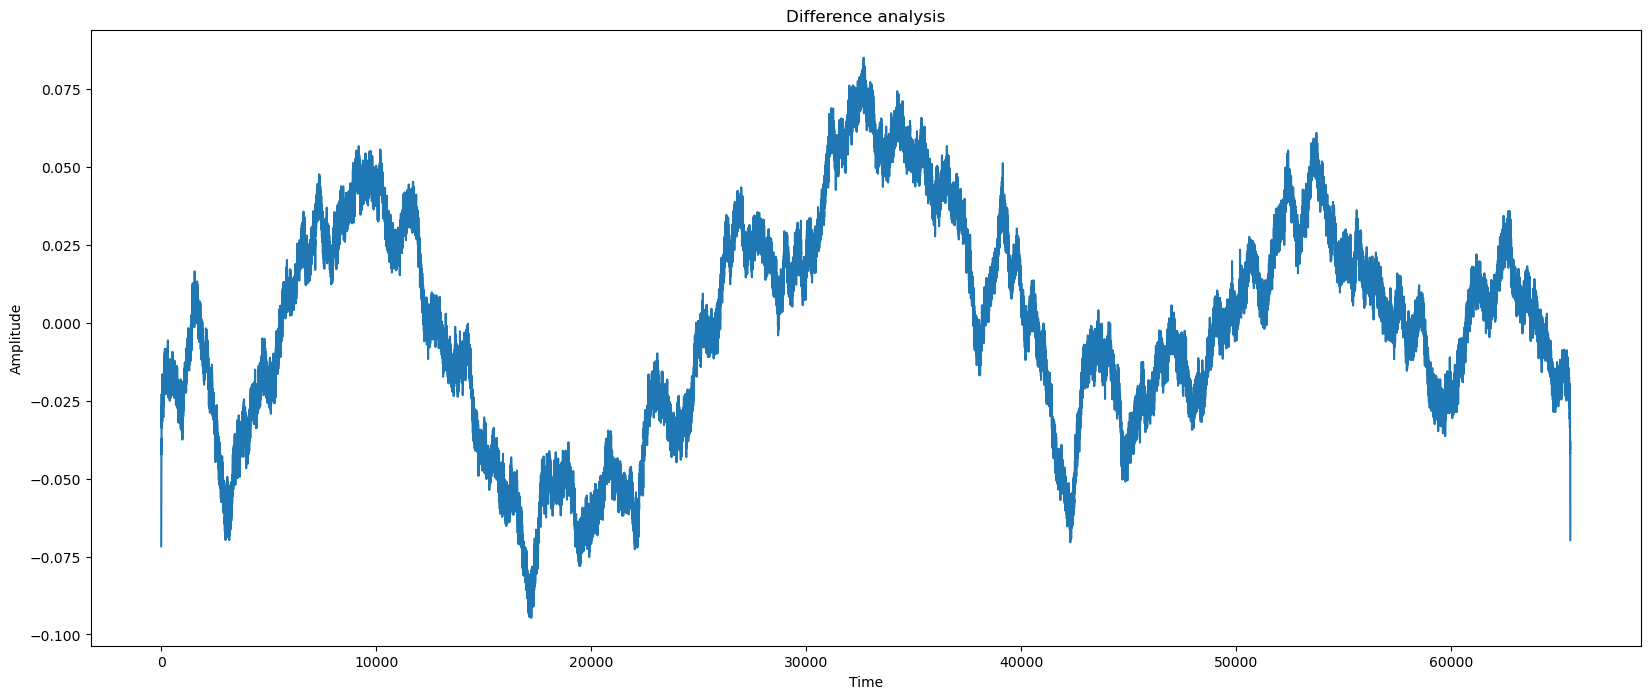

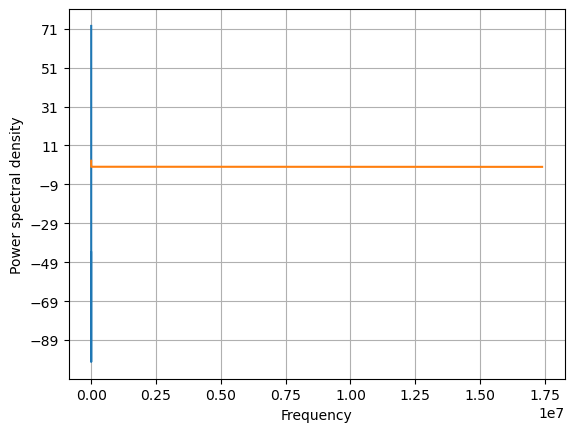

Median Analysis of signal
snr of the signal needed is:  63.38318616124973
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  84.49955024940508
Structure similarity index 0.9998265854178908
Mean of reconstructed_signal:  50.00740788778814
Median of reconstructed_signal:  50.008025452121394
Variance of reconstructed_signal:  0.0011474930694798963
Standard deviation of reconstructed_signal:  0.03387466707555804
Correlation between original and reconstructed_signal:  0.9961351976024705
frequency content/range of noise:  0.014740105840992612
Median Filter
snr: 63.38318616124973
nrmse: 0.0006773929804874024
tve: 0.007950599595301146
cr: 0.957195800692995
Kurtosis : -0.84887960677991
Skewness : 0.14449305288134331


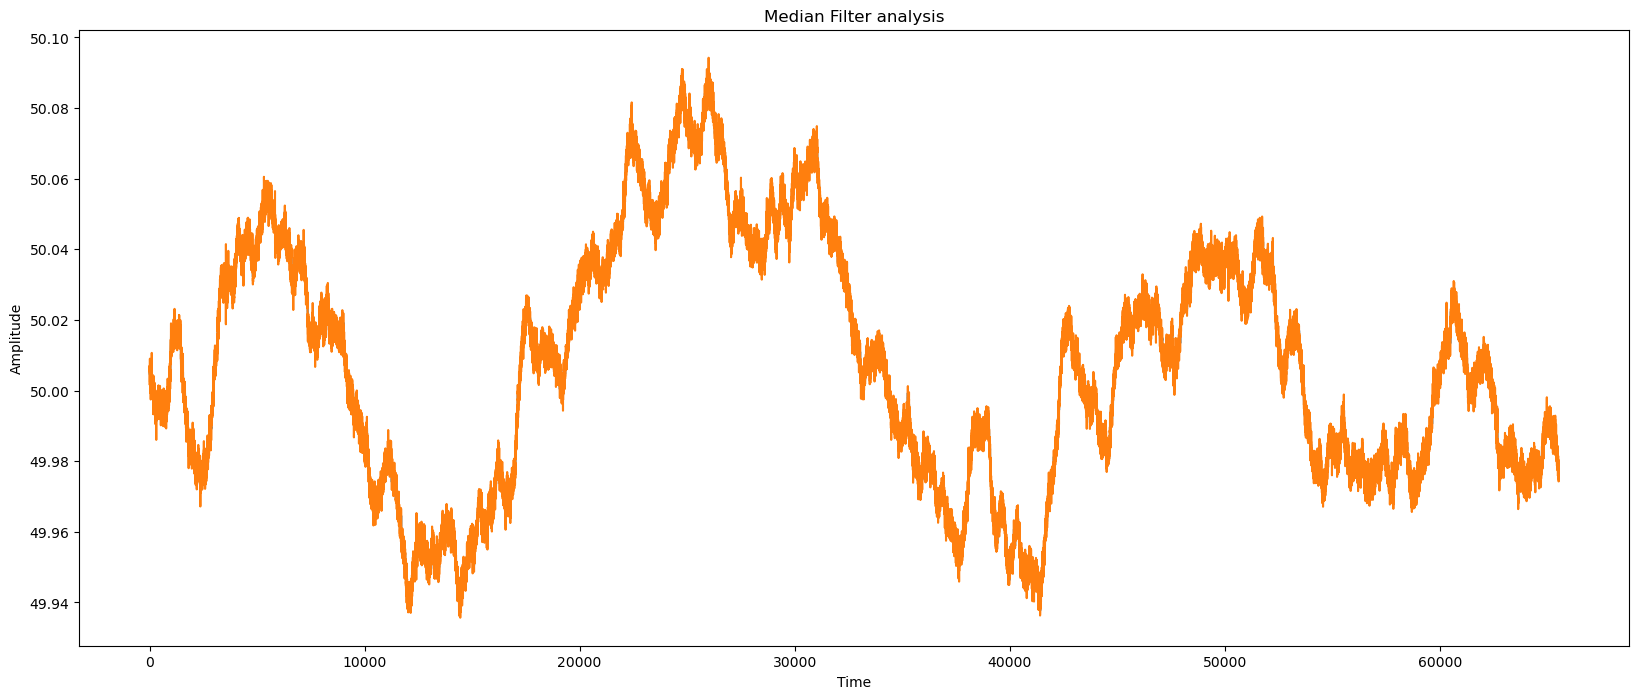

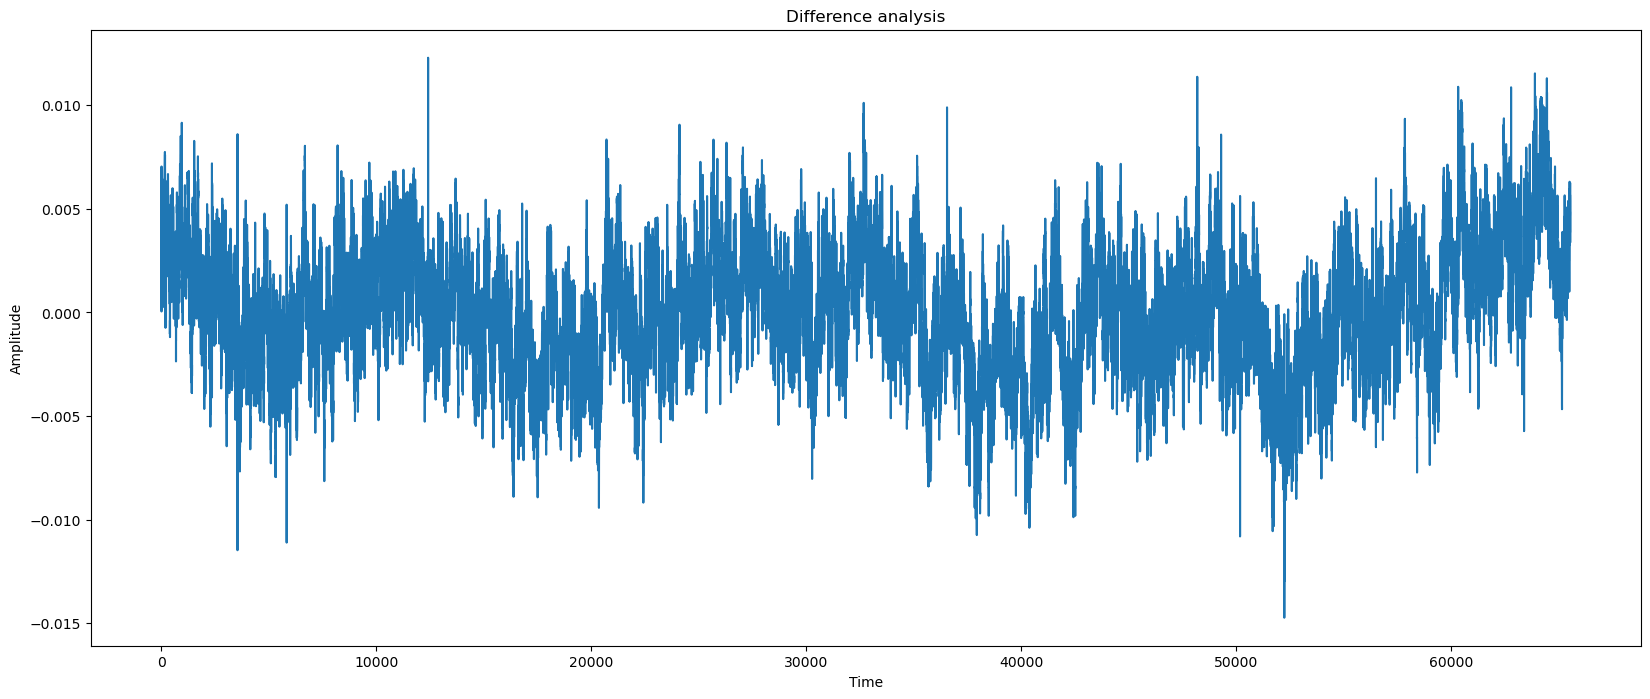

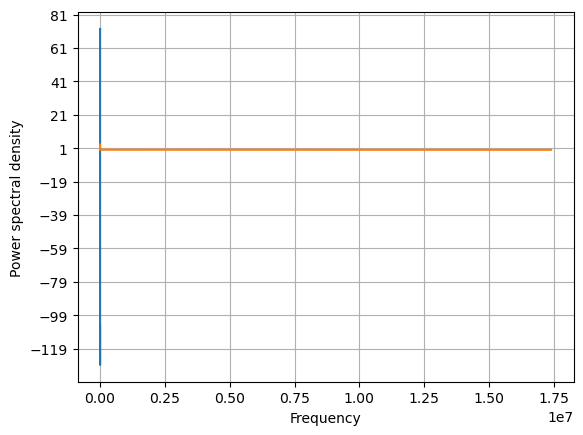

Triangular Analysis of signal
snr of the signal needed is:  50.35798720799019
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  50.599316568347454
Structure similarity index 0.9996881092897941
Mean of reconstructed_signal:  50.00592686239261
Median of reconstructed_signal:  50.00801458877254
Variance of reconstructed_signal:  0.023027364842180365
Standard deviation of reconstructed_signal:  0.15174770127478163
Correlation between original and reconstructed_signal:  0.22593033630499942
frequency content/range of noise:  20.838068518161432
Triangular Filter
snr: 50.35798720799019
nrmse: 0.003034594313037417
tve: 0.7566914641337033
cr: 132.03832044932048
Kurtosis : 13308.859735828964
Skewness : -108.29963633991207


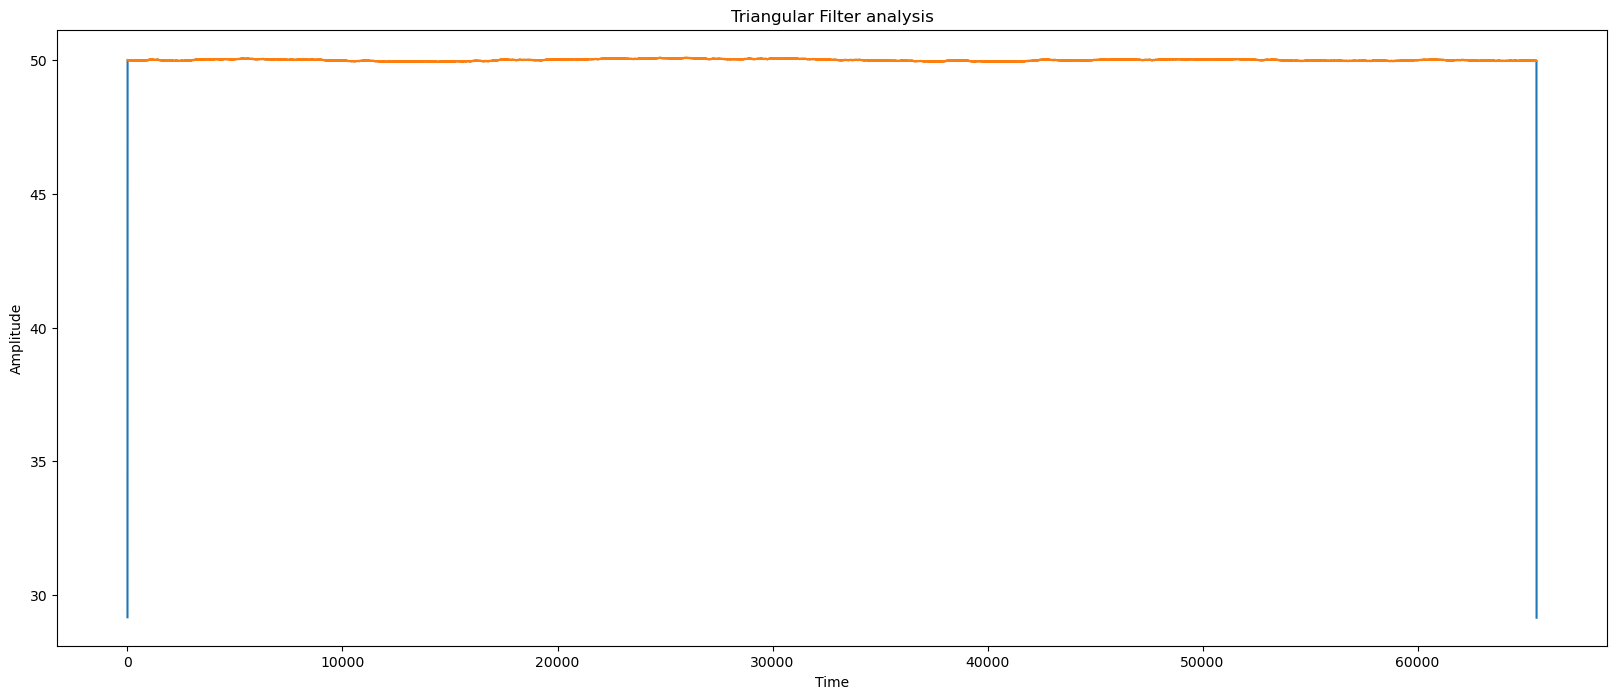

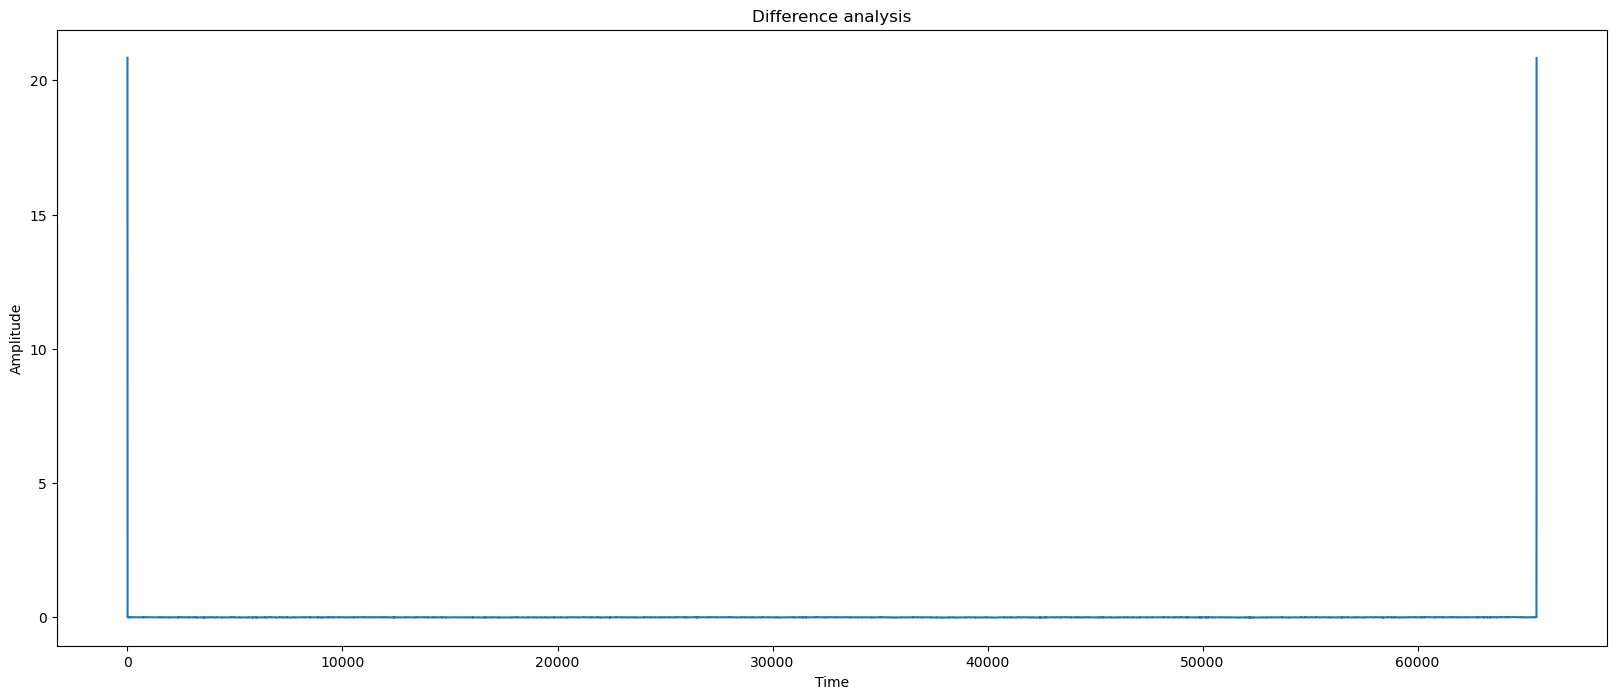

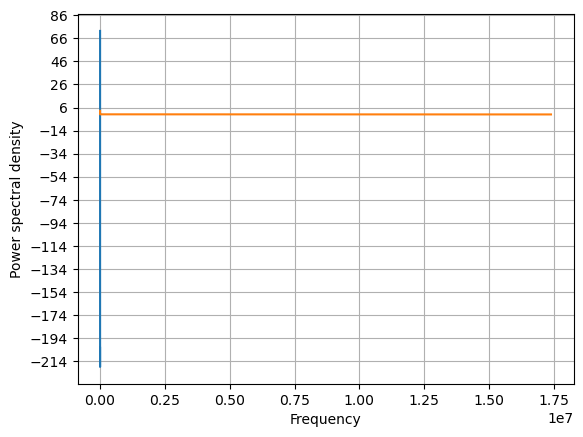

Wavelet Analysis of signal
snr of the signal needed is:  63.37914279440283
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  84.19070197067637
Structure similarity index 0.9997166942858678
Mean of reconstructed_signal:  50.00740882209381
Median of reconstructed_signal:  50.00795045174669
Variance of reconstructed_signal:  0.001148561948438932
Standard deviation of reconstructed_signal:  0.03389044036950438
Correlation between original and reconstructed_signal:  0.9958508386593179
frequency content/range of noise:  0.014050147282368641
Wavelet Filter
snr: 63.37914279440283
nrmse: 0.0006777083869726763
tve: 0.00570299520742053
cr: 0.9784526863900248
Kurtosis : -0.8475890499793493
Skewness : 0.1442894763680122


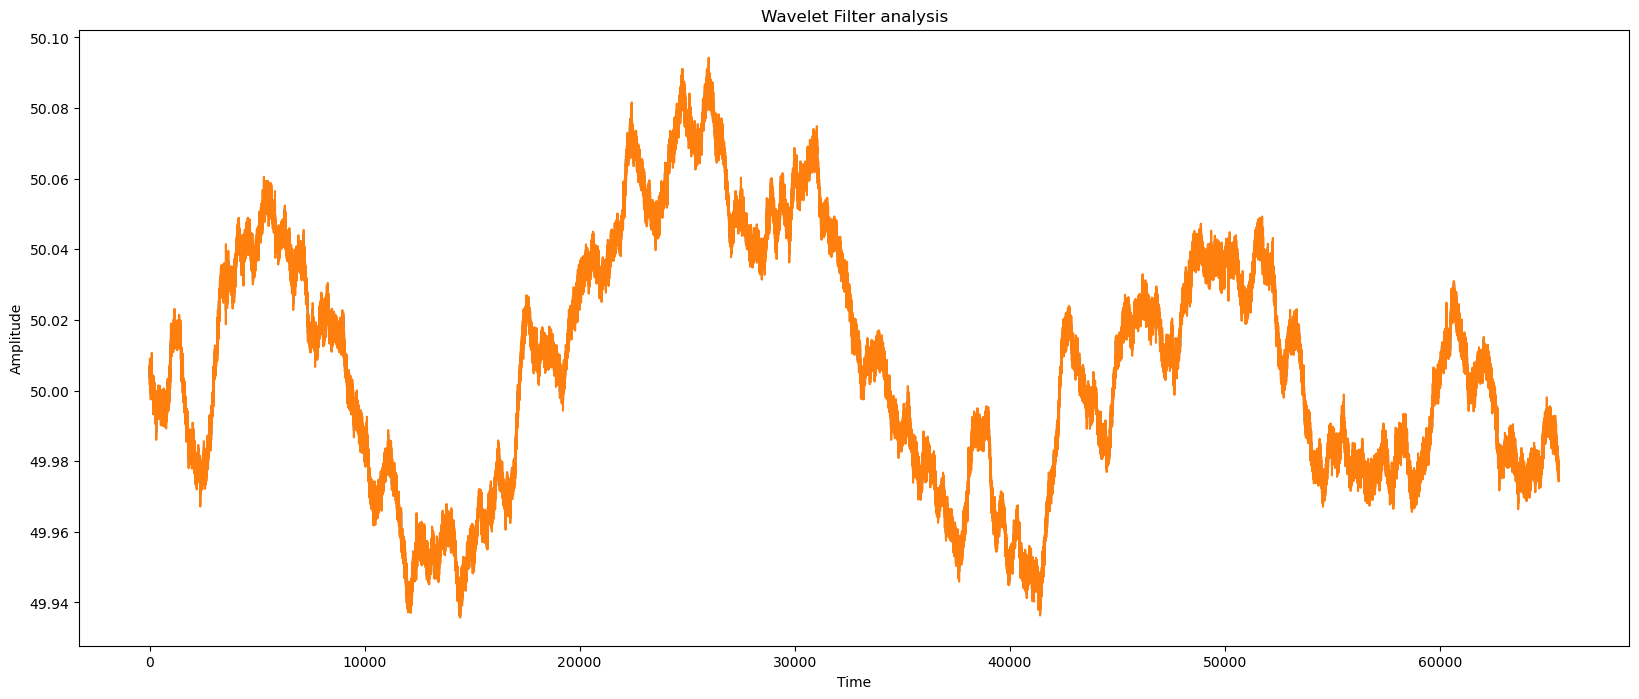

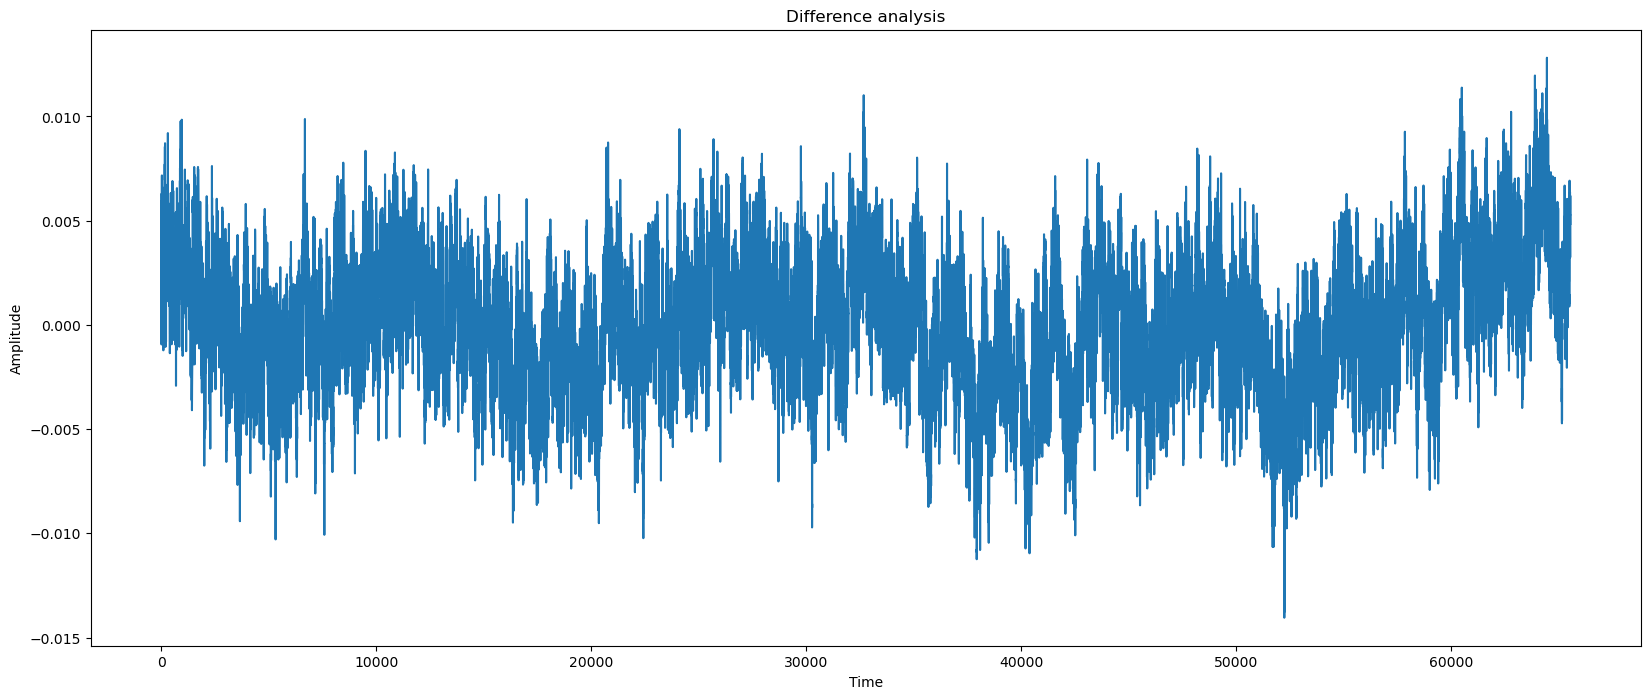

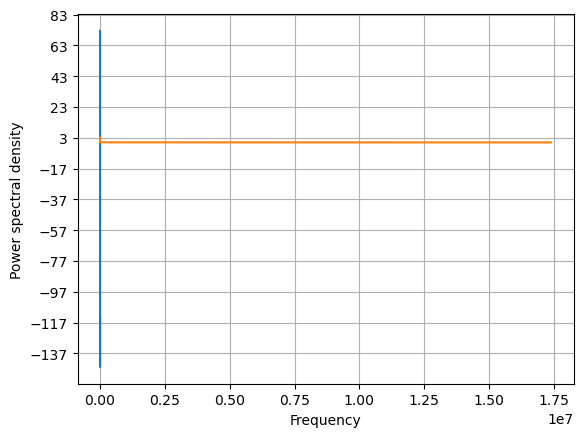

EIDFT Analysis of signal
snr of the signal needed is:  69.38127515487265
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  69.39093712514465
Structure similarity index 0.9999139278707353
Mean of reconstructed_signal:  50.007408804455636
Median of reconstructed_signal:  50.007871931762196
Variance of reconstructed_signal:  0.0002883640973523934
Standard deviation of reconstructed_signal:  0.016981286681296955
Correlation between original and reconstructed_signal:  0.999890339844553
frequency content/range of noise:  0.04091477862992576
EIDFT Filter
snr: 69.38127515487265
nrmse: 0.0003395754166687383
tve: 0.08752573053472566
cr: 0.4637084486960638
Kurtosis : -0.79658651249113
Skewness : 0.1344308232670232


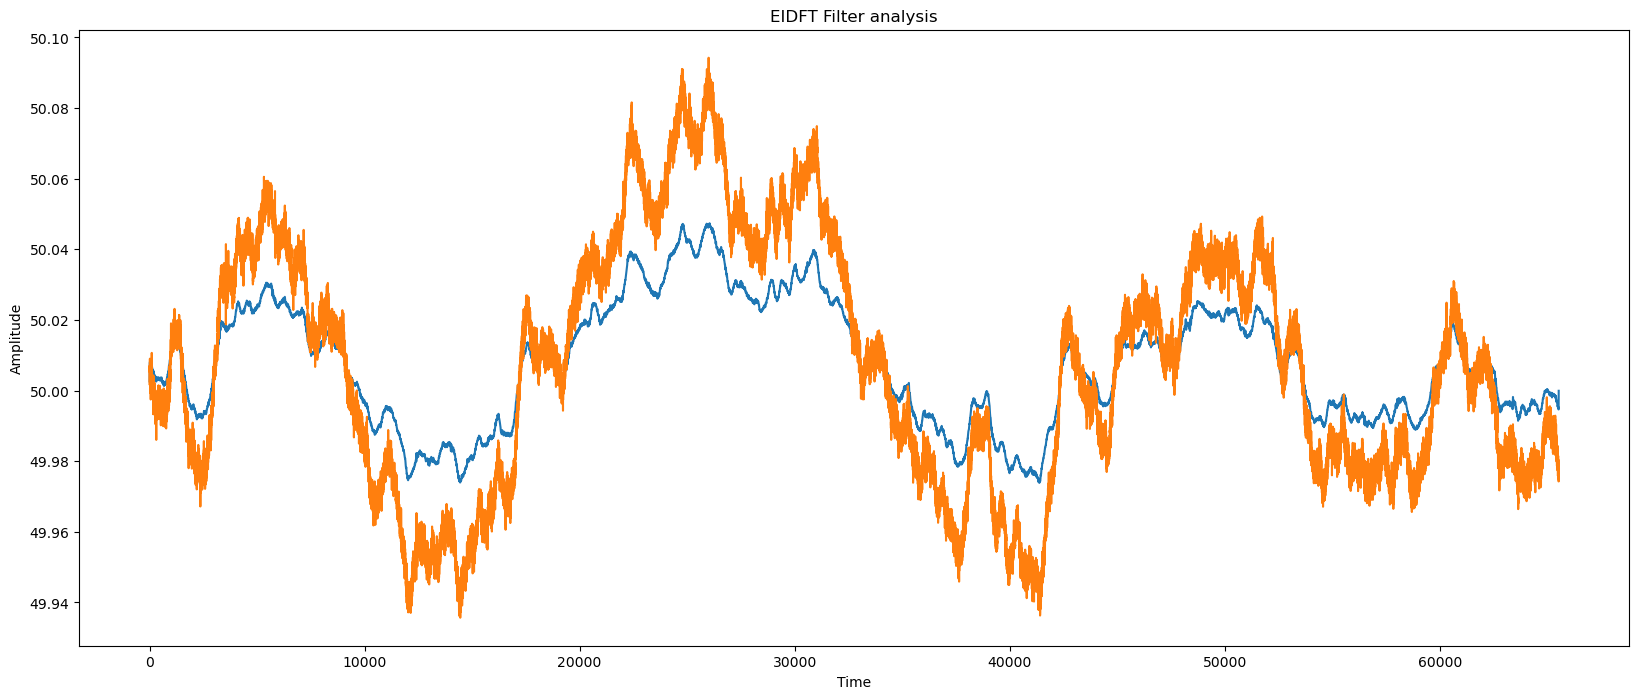

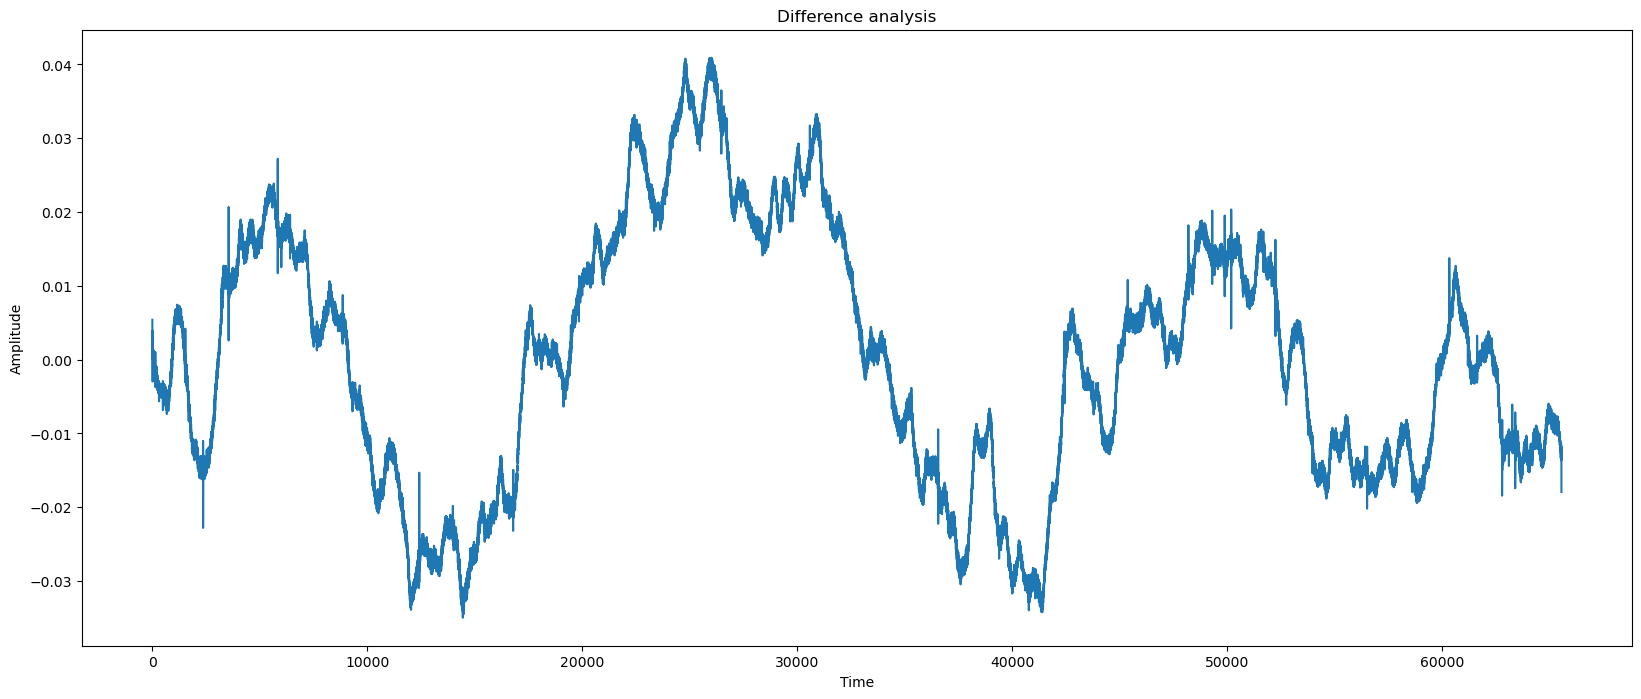

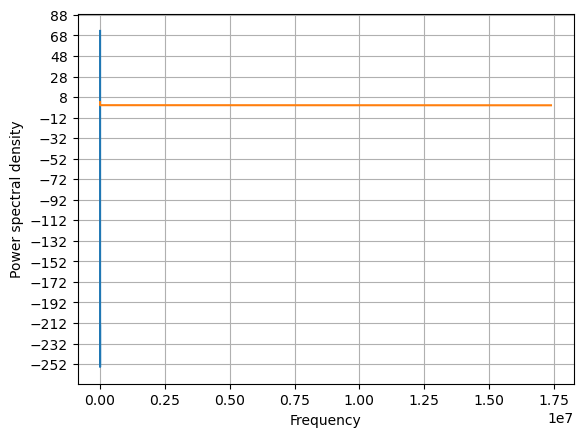

EKF Analysis of signal
snr of the signal needed is:  63.35962997195324
snr of the original signal is:  63.359398370474736
peaksnr of the signal needed is:  116.4119741610082
Structure similarity index 0.99999816134827
Mean of reconstructed_signal:  50.00740880442131
Median of reconstructed_signal:  50.00807517919881
Variance of reconstructed_signal:  0.0011537340392742852
Standard deviation of reconstructed_signal:  0.03396666070243416
Correlation between original and reconstructed_signal:  0.9999975163275431
frequency content/range of noise:  0.0015751073696321782
EKF Filter
snr: 63.35962997195324
nrmse: 0.0006792325680236218
tve: 0.01689813054863477
cr: 0.938414454803866
Kurtosis : -0.7962683996090929
Skewness : 0.13437583722009439


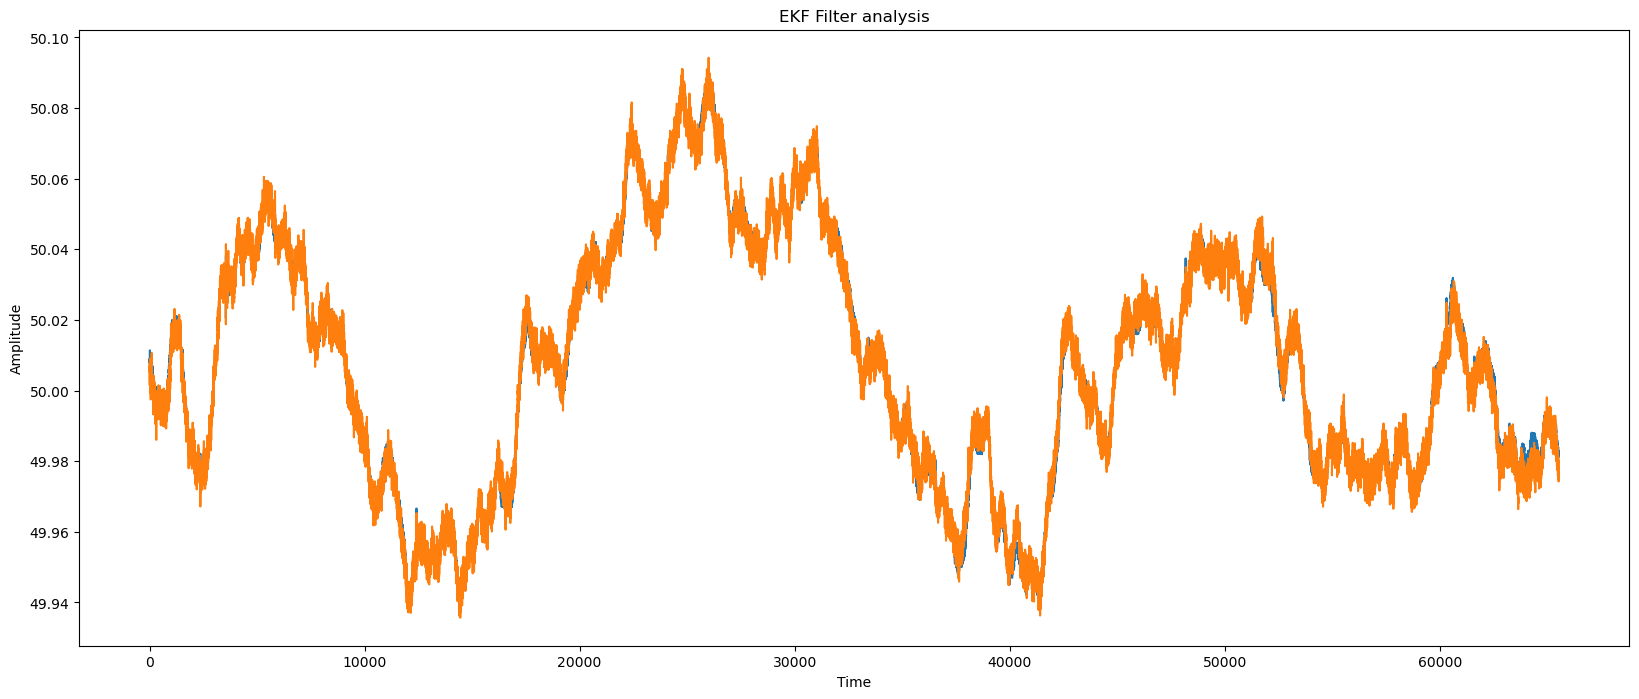

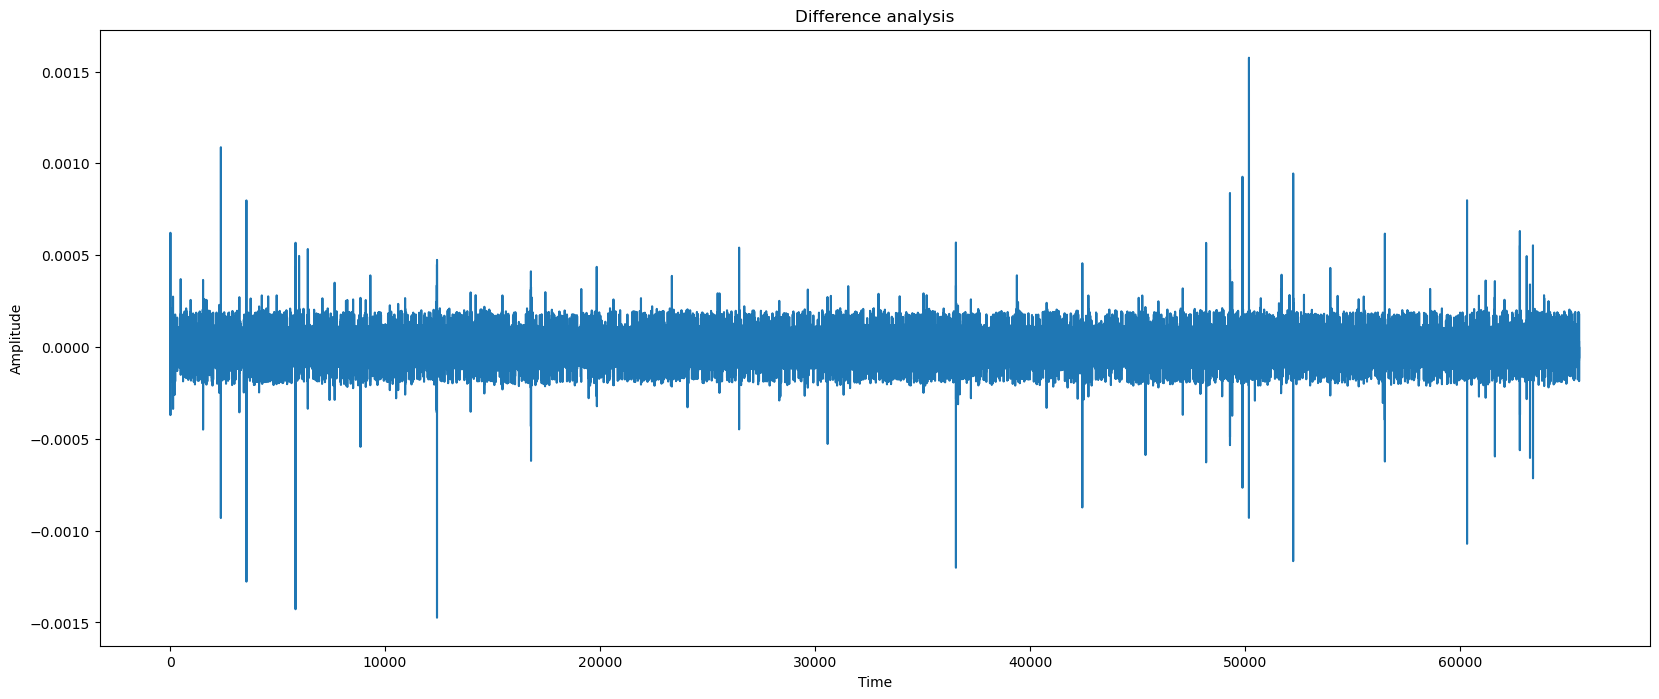

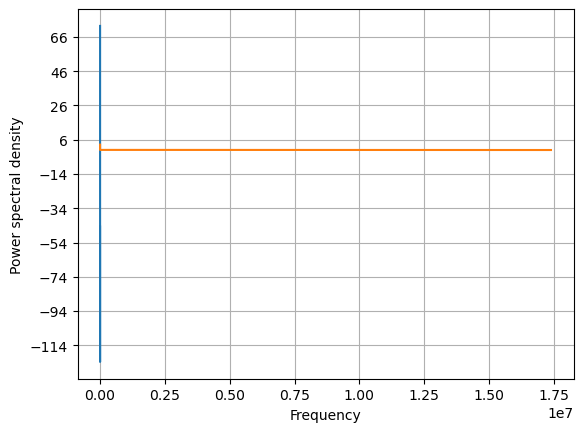

In [26]:
signal_analysis(df['BADARPUR:Frequency'], noise_type='0.1 inc pink')